# Text Classification Models

**Annotation:**

The project **aims** to develop a text classification model. To achieve this, the following steps will be taken:

1. Data Pre-processing
2. Exploratory Analysis
3. Data Preparation for Machine Learning
4. Model Selection and Training Algorithm
5. Training, Setting, Testing, and Checking Model Quality
6. Forecast and Conclusion

In alignment with the customer’s business objectives, the project involves creating a text classification model that will enable the company to identify toxic user comments and forward them for moderation (a binary text classification task).

**Data Source:**

The dataset provided by the customer contains data marked for toxicity in comments from online store customers.

**Tools and libraries:**
- Python
- Pandas
- Sklearn
- NLTK
- Numpy
- Transformers
- Matplotlib
- Seaborn

# Прогнозная модель для классификации текстов

**Аннотация проекта**

На данных интернет-магазина проводится исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании находить токсичные комментарии пользователей и отправлять их на модерацию.

**Цель исследования** — разработать модель для бинарной классификации текстов. Для этого будут выполнены следующие шаги:

- Предварительная обработка данных.
- Исследовательский анализ.
- Подготовка данных для машинного обучения.
- Выбор модели и алгоритма её обучения.
- Обучение, настройка, тестирование и оценка качества моделей.
- Прогноз и выводы.

Учитывая бизнес-задачи заказчика, предстоит разработать прогнозную модель и обучить её классифицировать комментарии на позитивные и негативные.

**Согласно условиям** показатель метрики качества модели *F1* должен составлять не меньше 0.75.

**Описание данных**

Датасет, представленный заказчиком, содержит данные с разметкой о токсичности правок и комментариев клиентов интернет-магазина.

**Инструменты и библиотеки:**
- Python
- Pandas
- Sklearn
- NLTK
- Numpy
- Transformers
- Matplotlib
- Seaborn

In [1]:
! pip install --upgrade scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# импорт библиотек, модулей и функций
import sklearn
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
import re, time
import warnings
import nltk

# классы для преобразования корпуса текстов
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

# модуль стоп-слов из библиотеки Natural Language Toolkit (nltk)
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# инструменты лемматизации
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# функция для разделения датасета на выборки
from sklearn.model_selection import train_test_split, cross_val_score

# инструменты для пайплайн
from sklearn.pipeline import Pipeline

# классы для моделей машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# инструменты для автоподбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# функция для расчёта метрики
from sklearn.metrics import f1_score, make_scorer, classification_report

# индикатор прогресса
from tqdm import notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milaz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\milaz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\milaz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Загрузка данных

- Загрузим файл и проверим, что данные в таблице соответствуют описанию.

In [3]:
# считываем данные из csv-файла и сохраняем в датафрейм
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

In [4]:
# выведем первые пять строк
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# выведем основную информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Вывод:**
- Данные загружены и корректно отображаются в таблице.
- Таблица включает два столбца: `text` — содержит текст комментария и `toxic` — целевой признак, где 1 значит текст «токсичный», а 0 это «не токсичный».
- Количество значений в столбцах не различается.
- Тип данных соответсвует содержанию.

## Анализ и предобработка данных

1. Построим графики и оценим характер распределения данных.
2. Проведем предобработку текста: токенизацию, лемматизацию, очистку от стоп-слов и ненужных символов, добавим маркеры начала и конца предложения, преобразуем токены в векторные представления.

In [6]:
# проверим уникальность значений по целевому признаку
df['toxic'].unique()

array([0, 1], dtype=int64)

In [7]:
# проверим дубликаты
df.duplicated().sum()

0

In [8]:
# проверим столбцы на наличие пустых значений
df.query('toxic == "" or toxic == " "')

,text,toxic


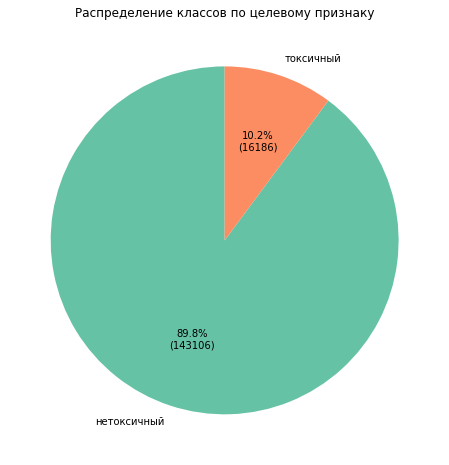

In [9]:
# рассмотрим распределение классов
class_distribution = df['toxic'].value_counts()
plt.figure(figsize=(10, 8))

# построим pie chart
labels = ['нетоксичный', 'токсичный']
colors = ['#66c2a5', '#fc8d62']

plt.pie(
    class_distribution,
    labels=labels,
    colors=colors,
    autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(class_distribution) / 100),
    startangle=90
)

plt.title('Распределение классов по целевому признаку')
plt.show()

**Вывод:**
- Целевой признак содержит значения двух классов — `0` и `1`.
- Пропущенных значений и дубликатов не обнаружено.
- Наблюдается существенный дисбаланс классов. Применение undersampling может негативно повлиять на обобщающие способности модели. Если класс большинства содержит редкие, но важные шаблоны для задачи (например, определенные темы в классификации текста), недостаточная выборка может привести к их исключению, что отрицательно скажется на способности модели распознавать их.
- Чтобы сохранить баланс классов при формировании выборок применим функцию `stratify`, которая учтёт разницу в классах таргета.

### Токенизация, лемматизация и очистка текста

Используем функцию `clean_text`, которая выполняет предварительную обработку входного текста с помощью `nltk` и лемматизатора `WordNet`.

Функция принимает текст, очищает его, удаляя неалфавитные символы и преобразуя в нижний регистр, маркирует очищенный текст, лемматизирует каждый токен и возвращает окончательный лемматизированный текст.

In [10]:
# инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# определение функции очистки
def clean_text(text):
    # очистка текста
    clean = " ".join(re.sub(r'[^a-zA-Z]', ' ', text).lower().split())
    # токенизация и POS tagging
    word_list = word_tokenize(clean)
    pos_tags = pos_tag(word_list)
    # лемматизация с учётом POS-тегов
    lemmatized_output = ' '.join([lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags])
    return lemmatized_output

# хелпер функция для сопоставления соответствия POS-тегов
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [11]:
%%time
# применение функции к столбцу с комментариями
df['text'] = df['text'].apply(clean_text)

Wall time: 19min 14s


In [12]:
# оценим результат
df.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


### Преобразование слов в векторные представления и визуализация данных

Преобразовать слова в векторы позволит модель «мешок слов» (англ. bag of words). Она преобразует текст в вектор, не учитывая порядок слов.

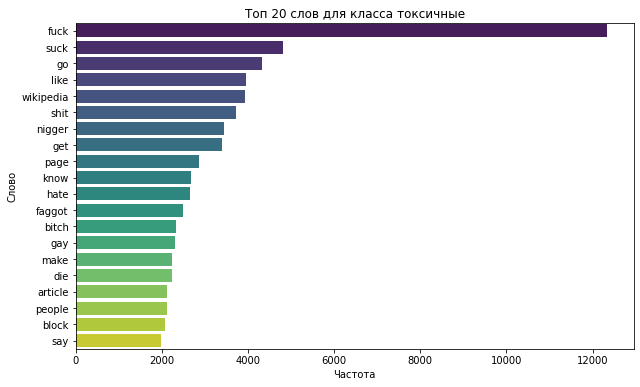

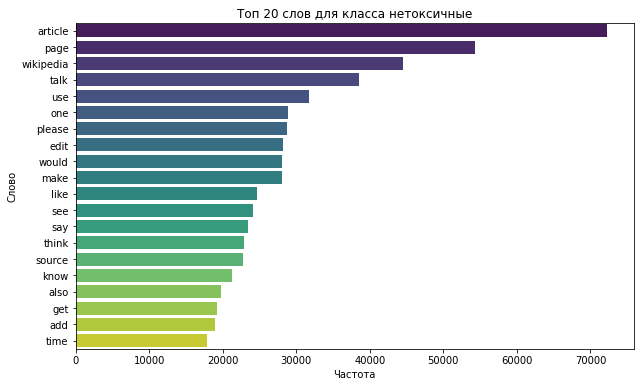

In [13]:
# фильтр данных по условиям токсичные / нетоксичные
toxic_lemm = df[df['toxic'] == 1]
nontoxic_lemm = df[df['toxic'] == 0]

# загрузка набора стоп-слов из библиотеки nltk
stop_words = list(nltk_stopwords.words('english'))

# визуализация классов
def visualize_top_words(class_df, title):
    # создание мешка слов
    corpus = list(class_df['text'])
    count_vect = CountVectorizer(max_features=20, stop_words=stop_words)
    bow = count_vect.fit_transform(corpus)

    # преобразование матрицы «мешок слов» в датафрейм
    feature_names = count_vect.get_feature_names_out()
    word_freq = bow.sum(axis=0).A1
    word_freq_df = pd.DataFrame({'Слово': feature_names, 'Частота': word_freq})

    # соритировка датафрейма по убыванию частоты встречаемости слов
    word_freq_df = word_freq_df.sort_values(by='Частота', ascending=False)

    # диаграммы топ 20 слов
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Частота', y='Слово', data=word_freq_df.head(20), palette='viridis')
    plt.title(f'Топ 20 слов для класса {title}')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.show()

# визуализация слов класса токсичные
visualize_top_words(toxic_lemm, 'токсичные')
# визуализация слов класса нетоксичные
visualize_top_words(nontoxic_lemm, 'нетоксичные')

**Вывод:**
- Согласно графикам предобработка текста прошла корректно. 
- Визуальная оценка позволяет говорить, что слова в мешке слов соответствуют представленным классам.

## Обучение моделей

Цель данного проекта — построить модель классификации текста для выявления токсичных и нетоксичных комментариев пользователей. Для этого выполним следующие шаги:
1. Преобразуем текстовые данные с помощью `TF-IDF` (частота термина, обратная частоте документа).
2. Протестируем две модели: `Support Vector Machines (SVM)` и `Logistic Regression`.
3. Для каждой подберём гиперпараметры, используя `RandomizedSearchCV` для поиска лучших гиперпараметров.
4. Оценим качество моделей метрикой `F1`, которая особенно полезна в случаях дисбаланса между классами, поскольку учитываются как ложноположительные, так и ложноотрицательные результаты. Более высокое значение указывает на лучшую производительность. Сбалансированный показатель F1 предполагает хороший компромисс между точностью и полнотой.

In [14]:
# разделяем датасет на выборки с учётом дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['toxic'], 
    test_size=0.2, 
    stratify=df['toxic'], 
    random_state=42
)

In [15]:
# опускаем предупреждения
warnings.filterwarnings('ignore')

In [ ]:
%%time
# pipeline
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', SVC())
])

# параметры для SVM
param_dist_svm = {
    'svm__C': [1],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale'],
    'svm__degree': [2],
}

# рандомизированный поиск лучшей модели и гиперпараметров
random_search_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist_svm,
    scoring='f1',
    n_iter=5,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# обучаем модель
random_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
# оценка SVM на обучающем наборе
train_score_svm = random_search_svm.score(X_train, y_train)
print("Оценка F1 на обучающей выборке:", train_score_svm)
print("Лучшие параметры:", random_search_svm.best_params_)

**Вывод:**
- Лучшая производительность **SVM** достигнута при параметрах: {'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'C': 1}. 
- Оценка **F1** на обучающей выборке составляет 0.80, что в целом удовлетворяет требования к качеству модели. 
- Вместе с тем, модель довольно затратна в плане временных ресурсов.

Далее оценим возможности **Logistic Regression**.

In [ ]:
%%time
# pipeline
pipeline_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('logreg', LogisticRegression())
])

# параметры для Logistic Regression
param_dist_logreg = {
    'logreg__C': [1, 6, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

# рандомизированный поиск лучшей модели и гиперпараметров
random_search_logreg = RandomizedSearchCV(
    pipeline_logreg,
    param_distributions=param_dist_logreg,
    scoring='f1',
    n_iter=5,
    cv=5,
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# обучаем модель
random_search_logreg.fit(X_train, y_train)

In [ ]:
# оценка Logistic Regression на обучающем наборе
train_score_logreg = random_search_logreg.score(X_train, y_train)
print("Оценка F1 на обучающей выборке:", train_score_logreg)
print("Лучшие параметры:", random_search_logreg.best_params_)

**Вывод:**
- Лучшая производительность **Logistic Regression** достигнута при параметрах: {'solver': 'saga', 'penalty': 'l1', 'C': 6}.
- Оценка **F1** на обучающей выборке составляет 0.83, что указывает на то, что логистическия регрессия справилась лучше. При этом, обучение модели заняло значительно меньше времени по сравнению с предыдущей.
- Таким образом, логистическая регрессия при текущих гиперпараметрах убедительно представляет свою эффективность в задачах бинарной классификации текстов.

Далее, оценим работу лучшей модели на тестовой выборке.

In [ ]:
# тестирование лучшей модели
best_model = random_search_logreg.best_estimator_

# получение предсказаний
y_pred = best_model.predict(X_test)

# оценка F1 на тестовой выборке
f1_test = f1_score(y_test, y_pred)
print("Оценка F1 на тестовой выборке:", f1_test)

In [ ]:
# рассмотрим подробные показатели классификации
print("Показатели производительности модели:\n", classification_report(y_test, y_pred))

**Вывод:**
- Оценка **F1** на тестовой выборке составляет 0.79. При этом, отчёт классификации отражает следующие характеристики:
- **Precision**: точность для класса 0 (нетоксичный) высокая (0.97). Это означает, что, когда модель прогнозирует комментарий как нетоксичный, это верно в 97 % случаев. Точность для класса 1 (токсичный) чуть ниже (0.87), что позволяет предположить, что когда модель предсказывает комментарий как токсичный, это верно в 87 % случаев.
- **Recall**: чувствительность модели для класса 0 высока (0.99), показатель указывает на то, что модель фиксирует 99 % реальных нетоксичных комментариев. Однако для класса 1 этот показатель значительно ниже (0.72), значит модели сложнее правильно идентифицировать токсичные комментарии.
- Оценка **F1** для класса 1 составляет 0.79, что отражает компромисс между *precision* и *recall*.
- **Accuracy**: общая точность составляет 96 %, что означает, что модель правильно предсказывает целевую переменную в 96 % случаев.

## Итоговый вывод

На данных интернет-магазина был проведён исследовательский анализ с последующей разработкой решения на основе моделирования, которое позволит компании находить токсичные комментарии пользователей и отправлять их на модерацию.

Учитывая бизнес-задачи заказчика, предстояло разработать прогнозную модель и обучить её классифицировать комментарии на позитивные и негативные (задача бинарной классификации текстов).

Работа включала предварительный этап, исследовательский анализ и предобработку данных, обучение разных моделей с подбором гиперпараметров, анализ моделей и проверку на тестовой выборке.

На **предварительном этапе** мы изучили основные сведения о датасете, определили количество и тип данных в таблице, проверили на наличие пропусков и убедились, что все данные отображаются корректно.

На этапе **исследовательского анализа и предобработки данных** были построены графики для оценки характера их распределения. Проведена предобработка, которая включала: токенизацию, лемматизацию, очистку от стоп-слов и ненужных символов, добавление маркеров начала и конца предложения, преобразование слов в векторные представления.

Этап **разработки модели** включал преобразование текстовых данных с помощью TF-IDF (частота термина, обратная частоте документа), настройку гиперпараметров, обучение модели, оценку её качества с использованием метрики *F1* и получение прогноза.

На этапе **анализа моделей** проводилось сопоставление результатов с учётом оценки качества прогноза и гиперпараметров.

В контексте поставленной задачи мы рассмотрели возможности следующих алгоритмов:
- `Logistic Regression` — часто служит базовой моделью для задач классификации текста, эффективна, когда связь между признаками и таргетом примерно линейна.
- `Support Vector Machines (SVM)` — эффективен для пространств большой размерности, что делает его пригодным для текстовых данных. Хорошо работает как для линейных, так и для нелинейных отношений.

**Основные результаты:**

1. Из двух моделей наиболее эффективной с точки зрения **прогнозных способностей** оказалась модель `Logistic Regression`. Оценка **F1** лучшей модели на **тренировочной** выборке составила *0.83*, на **тестовой** *0.79*. В целом модель работает хорошо, особенно при выявлении нетоксичных комментариев. Тем не менее, есть потенциал для улучшения выявления токсичных комментариев, о чем свидетельствует более низкий показатель *recall* и балл *F1* для класса 1.
- `Support Vector Machines (SVM)` также показала довольно убедительные оценки, однако, время обучения при текущих параметрах для указанной модели значительно более затратно по сравнению с моделью логистической регрессии. Оценка **F1** лучшей модели на **тренировочной** выборке составила *0.79*.
2. Согласно условиям показатель метрики качества модели F1 должен составлять не меньше 0.75, таким образом обе протестированные модели с запасом удовлетворяют условиям, однако время обучения существенно различается в зависимости от алгорима.
3. Таким образом, в данном контексте модель `Logistic Regression` оказалась более эффективной с точки зрения качества прогнозов и скорости обучения. Однако, способности протестированных алгоритмов не ограничевается рамками данного исследования. Обе модели имеют потенциал для улучшения с точки зрения настройки параметров при наличии ресурсных возможностей вычисления.